🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before).

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
!pip install segmentation-models-pytorch
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [2]:
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle
from pprint import pprint
from torch.utils.data import DataLoader
import pandas as pd
import gc

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [3]:
from google.colab import drive
drive.mount('/content/drive')

test_data = pickle.load(open('/content/drive/My Drive/Neural Nets/Final Project/lung_data/lung_cancer_test.pkl', 'rb'))

train_data = pickle.load(open('/content/drive/My Drive/Neural Nets/Final Project/lung_data/lung_cancer_train.pkl', 'rb'))



Mounted at /content/drive


In [4]:
data = pd.concat([train_data, train_data], ignore_index=True)
train_data = data.sample(800)
test_data = data.drop(train_data.index)


In [5]:
train_tensor = []
for i in range(len(train_data)):

  img_tensor = np.array(train_data.iloc[i]['hu_array'])
  img_tensor = torch.from_numpy(img_tensor)
  mask_tensor = np.array(train_data.iloc[i]['mask'])
  mask_tensor = torch.from_numpy(mask_tensor)
  train_tensor.append((img_tensor.unsqueeze(0), mask_tensor.unsqueeze(0)))

train_dataloader = DataLoader(train_tensor, batch_size=16, shuffle=True, num_workers= os.cpu_count())

test_tensor = []
for i in range(len(test_data)):

  img_tensor = np.array(test_data.iloc[i]['hu_array'])
  img_tensor = torch.from_numpy(img_tensor)
  mask_tensor = np.array(test_data.iloc[i]['mask'])
  mask_tensor = torch.from_numpy(mask_tensor)
  test_tensor.append((img_tensor.unsqueeze(0), mask_tensor.unsqueeze(0)))

test_dataloader = DataLoader(test_tensor, batch_size=16, shuffle=False, num_workers= os.cpu_count())


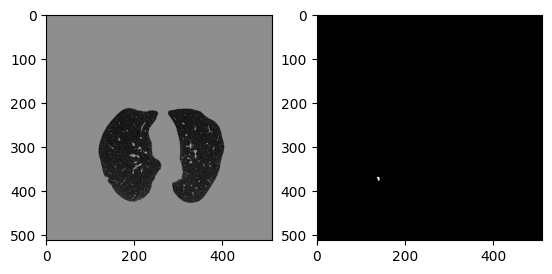

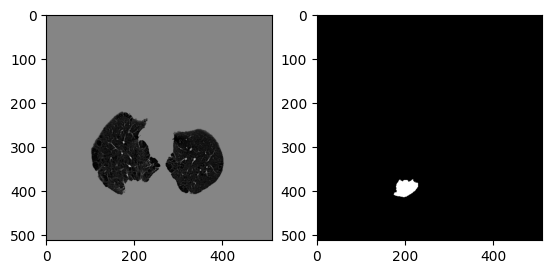

In [6]:
# lets look at some samples

sample = data.iloc[0]
plt.subplot(1,2,1)
plt.imshow(sample["hu_array"], cmap='gray') #.transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = data.iloc[230]
plt.subplot(1,2,1)
plt.imshow(sample["hu_array"], cmap='gray') #.transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze(), cmap='gray')  # for visualization we have to remove 3rd dimension of mask
plt.show()

# sample = test_dataset[0]
# plt.subplot(1,2,1)
# plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
# plt.subplot(1,2,2)
# plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
# plt.show()

In [7]:
del(test_data)
gc.collect()

11813

In [8]:
del train_data
gc.collect()

0

In [9]:
del data
gc.collect()

0

In [10]:
del img_tensor
gc.collect()

0

In [11]:
del mask_tensor
gc.collect()

0

In [12]:
del train_tensor
gc.collect()

0

In [13]:
del test_tensor
gc.collect()

0

## Model

In [14]:
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

        self.train_step_outputs = []
        self.validation_step_outputs = []

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch[0]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32,
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch[1]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image.float())

        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        if stage == "train":
          self.train_step_outputs.append(loss)
        else:
          self.validation_step_outputs.append(loss)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")

        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset
        # with "empty" images (images without target class) a large gap could be observed.
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }

        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")

    def on_train_epoch_end(self):
        epoch_average = torch.stack(self.train_step_outputs).mean()
        print(f"train epoch average: {epoch_average}")
        # self.train_step_outputs.clear()  # free memory

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def on_validation_epoch_end(self):
        epoch_average = torch.stack(self.validation_step_outputs).mean()
        print(f"val epoch average: {epoch_average}")
        # self.validation_step_outputs.clear()  # free memory

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [15]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 312MB/s]


## Training

In [16]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="auto"
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=test_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


val epoch average: 0.997295618057251


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.5697620511054993
train epoch average: 0.6984742283821106


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.42226704955101013
train epoch average: 0.3473484218120575


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.33595898747444153
train epoch average: 0.21741896867752075


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.3022722005844116
train epoch average: 0.17563705146312714


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.2660120725631714
train epoch average: 0.15213318169116974


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.25899046659469604
train epoch average: 0.14424829185009003


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.24970191717147827
train epoch average: 0.1369158923625946


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.24171164631843567
train epoch average: 0.1316937804222107


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.23462089896202087
train epoch average: 0.12838739156723022


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.24680201709270477
train epoch average: 0.12827149033546448


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.23194244503974915
train epoch average: 0.12087181955575943


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.23056675493717194
train epoch average: 0.12139451503753662


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.22828060388565063
train epoch average: 0.11376705020666122


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.20978228747844696
train epoch average: 0.10873503237962723


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.20579753816127777
train epoch average: 0.10895358771085739


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.2030058652162552
train epoch average: 0.10692058503627777


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.2007111757993698
train epoch average: 0.09955999255180359


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.19614645838737488
train epoch average: 0.10257121175527573


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1978641152381897
train epoch average: 0.10154006630182266


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.19352556765079498
train epoch average: 0.10770634561777115


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.19238613545894623
train epoch average: 0.09732536226511002


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1946190595626831
train epoch average: 0.09817244112491608


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1938164085149765
train epoch average: 0.10094993561506271


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18710632622241974
train epoch average: 0.09365953505039215


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18732455372810364
train epoch average: 0.09256822615861893


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18655994534492493
train epoch average: 0.09481455385684967


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18351507186889648
train epoch average: 0.09466241300106049


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18524006009101868
train epoch average: 0.09097099304199219


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1842440813779831
train epoch average: 0.09074363857507706


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18128664791584015
train epoch average: 0.09048160165548325


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.17822059988975525
train epoch average: 0.0897965207695961


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1789054572582245
train epoch average: 0.08741842210292816


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1739082783460617
train epoch average: 0.08624608814716339


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.17614315450191498
train epoch average: 0.08507215231657028


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.18037310242652893
train epoch average: 0.09271159023046494


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.17394736409187317
train epoch average: 0.0849180668592453


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16942362487316132
train epoch average: 0.0848197340965271


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16869358718395233
train epoch average: 0.08503446727991104


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16779574751853943
train epoch average: 0.08538434654474258


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16691355407238007
train epoch average: 0.0844532772898674


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1646934151649475
train epoch average: 0.08269209414720535


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16372811794281006
train epoch average: 0.08187546581029892


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.170509472489357
train epoch average: 0.08040487766265869


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16691471636295319
train epoch average: 0.07845766842365265


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16506721079349518
train epoch average: 0.08379129320383072


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16067421436309814
train epoch average: 0.08579783141613007


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16138587892055511
train epoch average: 0.0796288251876831


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16132232546806335
train epoch average: 0.08098094910383224


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15846949815750122
train epoch average: 0.07780931890010834


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15759123861789703
train epoch average: 0.08020896464586258


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16146576404571533
train epoch average: 0.08131391555070877


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1588423252105713
train epoch average: 0.07806011289358139


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15801508724689484
train epoch average: 0.08141851425170898


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1593640148639679
train epoch average: 0.0788639485836029


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1565062403678894
train epoch average: 0.07579997181892395


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16166672110557556
train epoch average: 0.08128204196691513


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15961426496505737
train epoch average: 0.07968464493751526


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16081617772579193
train epoch average: 0.0769881084561348


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15734051167964935
train epoch average: 0.07390322536230087


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.156950905919075
train epoch average: 0.07603279501199722


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15765154361724854
train epoch average: 0.07538671791553497


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16268794238567352
train epoch average: 0.0834779441356659


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16246317327022552
train epoch average: 0.07671556621789932


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1551862359046936
train epoch average: 0.0752444937825203


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15640957653522491
train epoch average: 0.07863369584083557


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15080919861793518
train epoch average: 0.07264496386051178


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15162868797779083
train epoch average: 0.07228219509124756


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15434756875038147
train epoch average: 0.07698895782232285


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16431139409542084
train epoch average: 0.07695049047470093


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15782210230827332
train epoch average: 0.07475204765796661


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.154982790350914
train epoch average: 0.07470047473907471


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.2878513038158417
train epoch average: 0.1010144054889679


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.16354218125343323
train epoch average: 0.09538944065570831


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15972523391246796
train epoch average: 0.07930836081504822


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1562967747449875
train epoch average: 0.07556957006454468


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15456436574459076
train epoch average: 0.07749050110578537


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15226662158966064
train epoch average: 0.07438810914754868


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15316222608089447
train epoch average: 0.07419411838054657


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15237587690353394
train epoch average: 0.07348213344812393


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.150232195854187
train epoch average: 0.07088885456323624


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15465475618839264
train epoch average: 0.07560674846172333


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15125003457069397
train epoch average: 0.07446085661649704


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1483442336320877
train epoch average: 0.07269112020730972


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14779239892959595
train epoch average: 0.07241014391183853


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14947673678398132
train epoch average: 0.06999824196100235


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.15209269523620605
train epoch average: 0.08101903647184372


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14927077293395996
train epoch average: 0.07609520852565765


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14731508493423462
train epoch average: 0.07175632566213608


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14629054069519043
train epoch average: 0.06979496031999588


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14915034174919128
train epoch average: 0.07497196644544601


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14981602132320404
train epoch average: 0.07009509205818176


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14890950918197632
train epoch average: 0.07191712409257889


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14814242720603943
train epoch average: 0.0706205815076828


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14684517681598663
train epoch average: 0.07081005722284317


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14548957347869873
train epoch average: 0.06680800765752792


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1450767070055008
train epoch average: 0.06670178472995758


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14611808955669403
train epoch average: 0.0665411725640297


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.1476380079984665
train epoch average: 0.0772460550069809


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14644351601600647
train epoch average: 0.06892184168100357


Validation: |          | 0/? [00:00<?, ?it/s]

val epoch average: 0.14487765729427338
train epoch average: 0.07271406799554825


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


# Result visualization

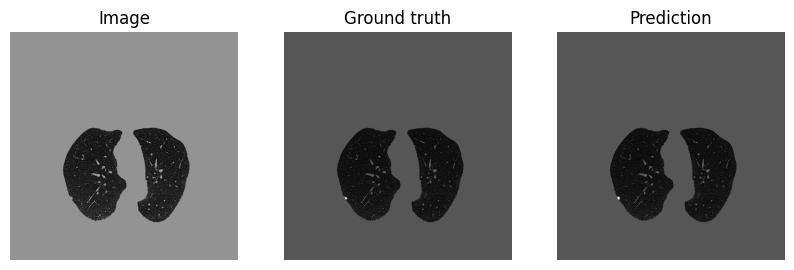

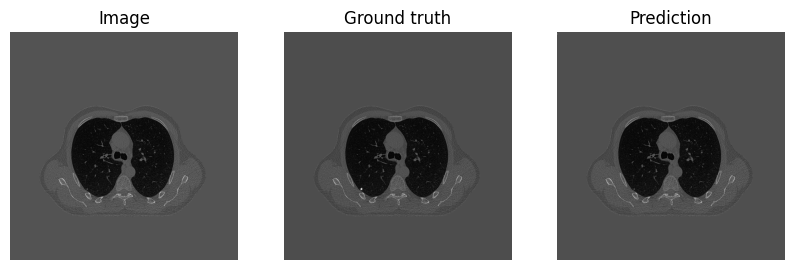

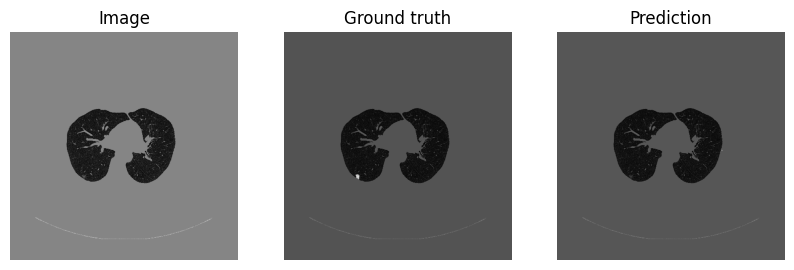

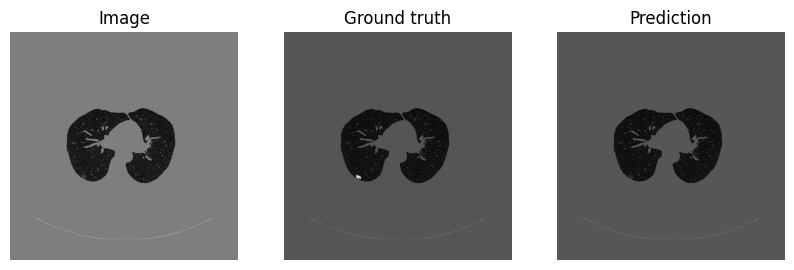

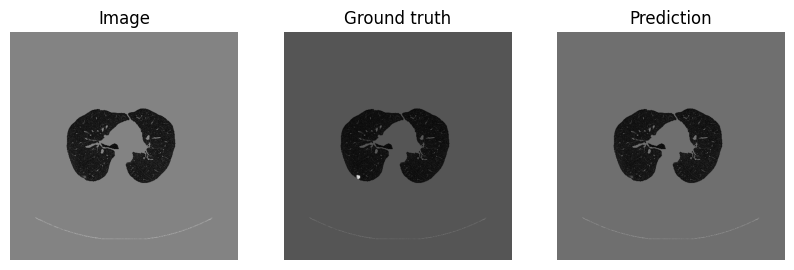

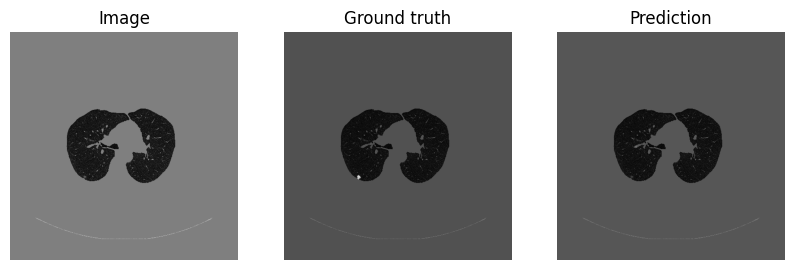

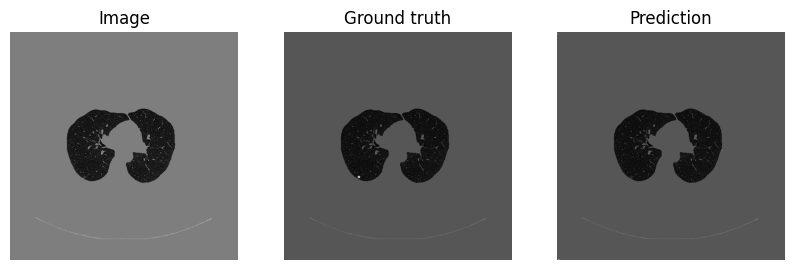

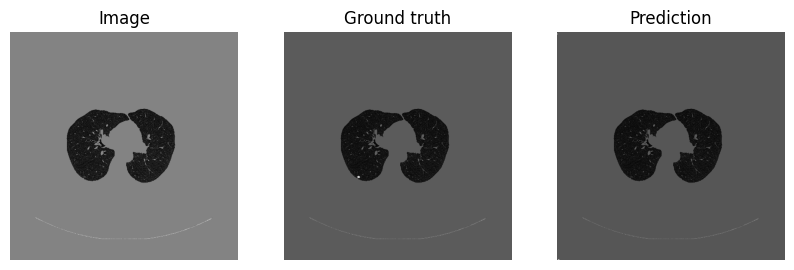

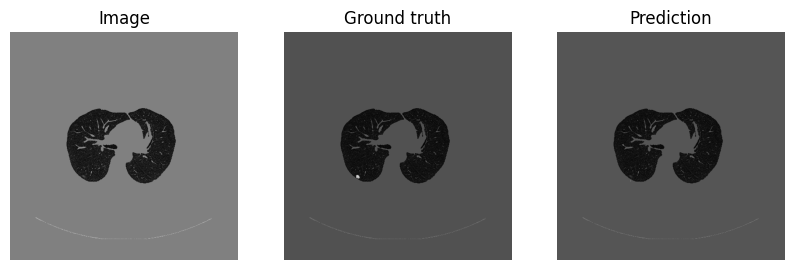

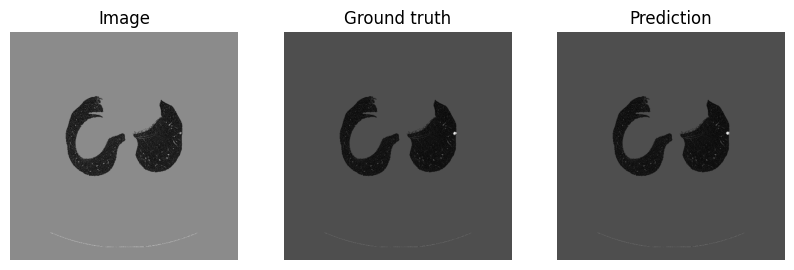

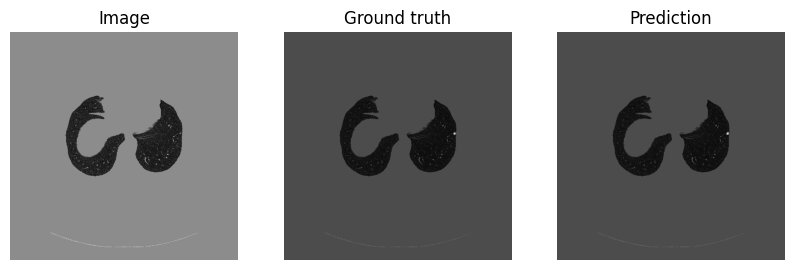

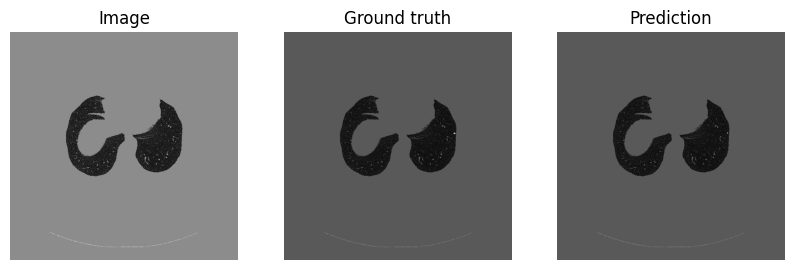

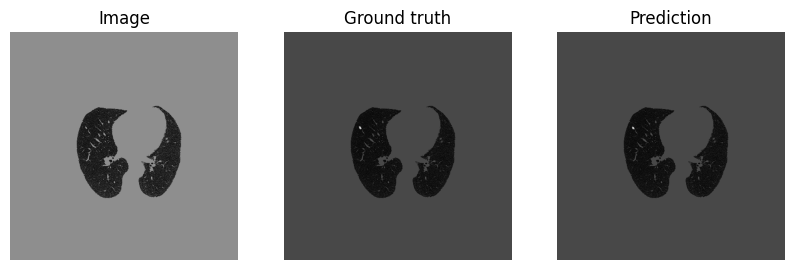

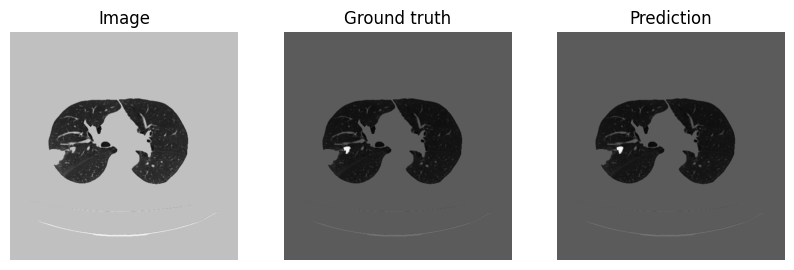

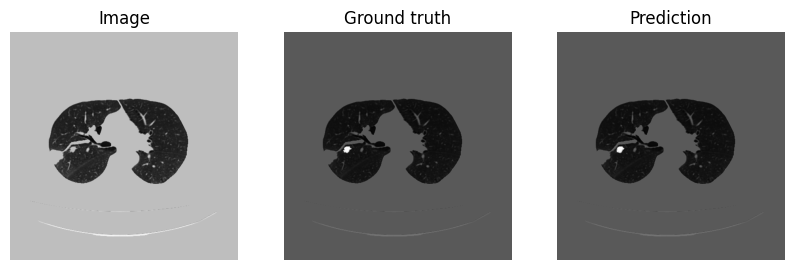

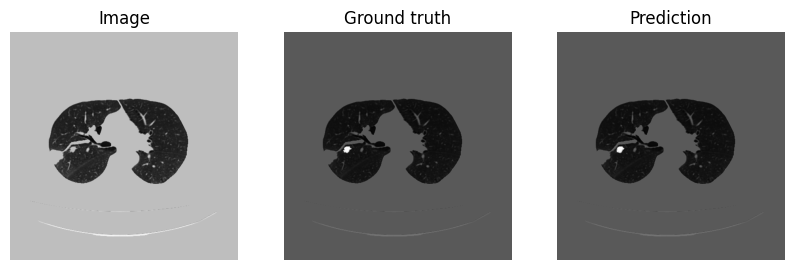

In [18]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch[0].float())
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch[0], batch[1], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    t = (gt_mask + image* .0005)
    # plt.imshow(gt_mask.numpy().squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
    plt.imshow(t.numpy().transpose(1, 2, 0), cmap='gray')
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    pr_mask = ((pr_mask - pr_mask.min()) / (pr_mask.max() - pr_mask.min()) >.5).int()
    t = (pr_mask + image* .0005)
    plt.imshow(t.numpy().transpose(1, 2, 0), cmap='gray')
    # plt.imshow(pr_mask.numpy().squeeze(), cmap='gray') # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

In [19]:
torch.save(model, '/content/drive/My Drive/Neural Nets/Final Project/hundred_epochs')

In [20]:
x = torch.load('/content/drive/My Drive/Neural Nets/Final Project/hundred_epochs')

In [24]:
model.train_step_outputs

[]